In [1]:
%pylab notebook

# Run on CPU not GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from primo.models.cas9_keras import log10_crispr_spec, log10_norm_crispr_spec,linear_crispr_spec
import primo.tools.sequences as seqtools
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-gijg_cgq because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Populating the interactive namespace from numpy and matplotlib


In [2]:
### 
# Take a pair of flat vectors as starting points, and slowly change them to a final point
###

from scipy.interpolate import interp1d

def dotproduct_crispr_spec(seq_pairs):
    """Alternative cleave rate model
    
    Normalize the softmax inputs, and take the penalty at each position to be
    one minus the dot product of the two "base vectors", weighted according to the 
    position dependent substitution penalty from the finkelstein paper.
    
    This ignores the base dependent weighting -- i.e. difference between substituting
    A, T, C, or G -- but allows base outputs which are less confident but still
    similar to be evaluated as such during training. 
    
    With the previous function, an input like [0.8, 0.066, 0.066, 0.0.66] / [0.8, 0.066, 0.066, 0.0.66]
    at a single base results in a substantial penalty to cleave rate.
    """
    subpen = np.array([-1.7449405080809126, -1.275485084790358, -1.8001827224086722, -1.9323849500279549, -1.6677722398632207, -1.6537370694565101, -1.8981469677400609, -1.0814292717607923, -1.3231152511430453, -0.99840146446464273, -1.2766126030502924, -1.073338813454068, -1.5614374592181826, -1.4737507320504855, -1.298392565410591, -1.0105000195452765, -0.43349702574711524, -0.11665543376814178, -0.17370266801790191, 0.2676084623705467, 0.051835157750172757, 0.08920809165894289, 0.075459598643889569, 0.046975071077932237]).astype(np.float32)
    subpen = subpen[:20][::-1]
    ref, _ = tf.linalg.normalize(seq_pairs[:, 0, :, :], axis=-1)
    obs, _ = tf.linalg.normalize(seq_pairs[:, 1, :, :], axis=-1)
    
    x = 1 -  tf.reduce_sum(ref*obs, axis=-1)
    
    scores = tf.reduce_sum(x * tf.constant(subpen.flatten(), dtype=tf.float32), -1)
    return scores

def dotproduct_linearized(mid_point=None):
    """Returns a predictor function which will scale the log10 scores such that the
    given `mid_point` value is 0.5.
    
    mid_point is the output of log10_crispr_spec, and shoudl be on range [log10_lb, log10_ub]
    
    If mid_point is none, cleave rate is linearized; i.e. return 10**log_10_crispr_spec(x)
    """
    power = 10
    if mid_point is not None:
        power = 0.5 ** (1 / mid_point)

    def f(seq_pairs):
        """
        seq_pairs batch_size x 2 x SEQLEN x 4
        """
        scores = power ** dotproduct_crispr_spec(seq_pairs)
        confidence = tf.reduce_mean((tf.reduce_max(seq_pairs, -1) - 0.25)/0.75, axis=2)
        confidence = tf.reduce_prod(confidence, axis=1)
        return 0.5 + (scores - 0.5), confidence

    return f


def plot_transition(final_pairs):
    # Start from a completely random softmax vector, where every position has 
    # 25% probaility of being each base
    random_seq = np.repeat(np.array([0.25, 0.25, 0.25, 0.25])[:, None], 20, axis=1).T
    start_pair = np.repeat(random_seq[None, :, :], 2, axis=0)
    
    # Create softmax version of the ending pair sequence values
    end_pair = seqtools.seqs_to_onehots(final_pairs)
    
    # create array of softmax pairs by interpolating between the start and end,
    # to simulate the training path of moving from random vectors to that
    # particular onehot vector
    end_interp = interp1d([0.0, 1.0], np.array([start_pair, end_pair]), axis=0)
    x = np.linspace(0.0, 1.0, 100)
    pair_array = end_interp(x)
    
    scores, confidence = dotproduct_linearized()(tf.convert_to_tensor(pair_array, dtype=np.float32))
    old_scores = linear_crispr_spec()(tf.convert_to_tensor(pair_array, dtype=np.float32))
    plt.figure()
    plt.plot(x, scores, label='score')
    plt.plot(x, confidence, label='confidence')
    plt.plot(x, 0.5 + (scores - 0.5) * confidence, label='product')
    plt.plot(x, old_scores, label='original')
    plt.suptitle(f"{final_pairs[0]}\n{final_pairs[1]}", fontdict={'family': 'monospace'})
    plt.legend(loc='upper center')

pair1 = [
    'AAAAAAAAAAAAAAAAAAAA',
    'AAAAAAACCGGAAATTTAAA',
]
pair2 = [
    'AAAAAAACCGGAAATTTAAA',
    'AAAAAAACCGGAAATTTAAA',
]

plot_transition(pair1)
plot_transition(pair2)





Last score: 0.14730629324913025 


In [18]:
alpha = seqtools.seqs_to_onehots(['ACAGAAGGAGCGCGGCTAAA'])
#beta = alpha seqtools.seqs_to_onehots(['ACAGAAGGAGGGCGGCTAAA'])
NSAMPLES = 100


vectors = alpha

for pos in reversed(np.arange(13, 19)):
    start = vectors[-1]
    transit = np.zeros((NSAMPLES, 20, 4))
    cur_idx = np.argmax(start[pos, :])
    new_idx = (cur_idx + 1) % 4
    transit[:, pos, new_idx] = np.linspace(0.0, 1.0, NSAMPLES)
    transit[:, pos, cur_idx] = np.linspace(0.0, -1.0, NSAMPLES)
    new_samples = start + transit
    vectors = np.concatenate([vectors, new_samples])

    
# # Transition from [0, 1, 0, 0] ('T') to [0, 0, 1, 0] ('C') iteratively in base 16
# transit1 = np.zeros((NSAMPLES, 20, 4))
# transit1[:, 16, 2] = np.linspace(0.0, 1.0, NSAMPLES)
# transit1[:, 16, 1] = np.linspace(0.0, -1.0, NSAMPLES)
# vectors = alpha + transit10.25, 0.25, 0.25, 0.25

# # Transition from [1, 0, 0, 0] ('A') to (0, 1, 0, 0) ('T') iteratively in base 17
# transit2 = np.zeros((NSAMPLES, 20, 4))
# transit2[:, 17, 1] = np.linspace(0.0, 1.0, NSAMPLES)
# transit2[:, 17, 0] = np.linspace(0.0, -1.0, NSAMPLES)
# start = vectors[-1]

# # Transition from [1, 0, 0, 0] ('A') to (0, 1, 0, 0) ('T') iteratively in base 18
# transit3 = np.zeros((NSAMPLES, 20, 4))
# transit3[:, 18, 1] = np.linspace(0.0, 1.0, NSAMPLES)
# transit3[:, 18, 0] = np.linspace(0.0, -1.0, NSAMPLES)
# start = vectors[-1]

# vectors = np.concatenate([vectors, start + transit3])

pairs = tf.convert_to_tensor(
    np.stack([np.repeat(alpha, len(vectors), axis=0), vectors], axis=1),
    dtype=tf.float32
)
scores = linear_crispr_spec(-1.3)(pairs)
print(f"Last score: {scores[-1]} ")

Last score: 0.017060143873095512 


In [19]:
np.arange(19, 0)

array([], dtype=int64)

In [20]:
seqtools.bases.arg('A')

AttributeError: 'numpy.ndarray' object has no attribute 'arg'

<IPython.core.display.Javascript object>


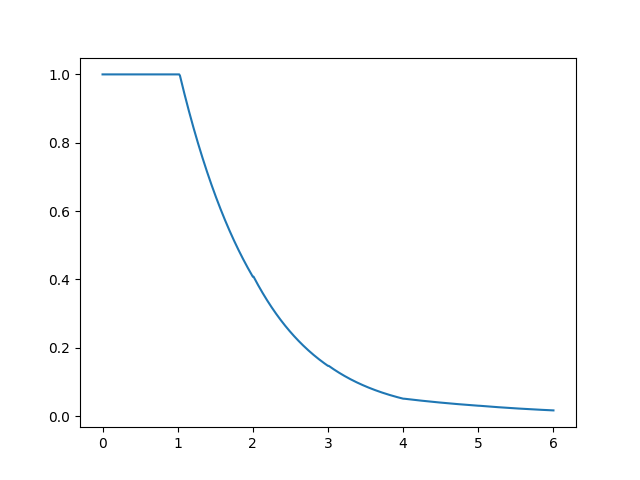

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(len(scores)) / 100.0, scores)
#ax.set_ylabel('log10 cleave rate')

<IPython.core.display.Javascript object>


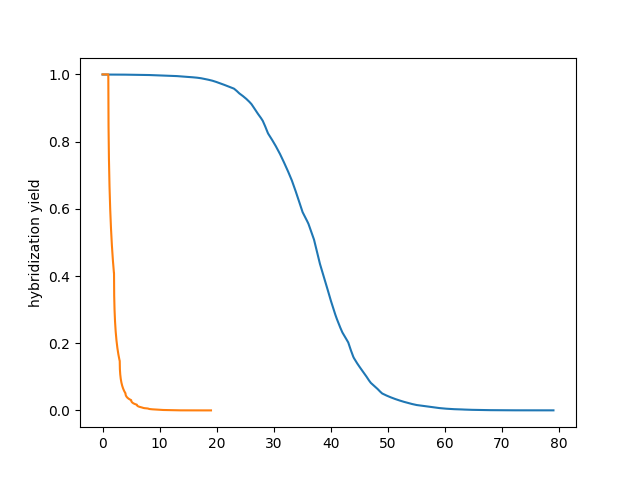

Text(0, 0.5, 'hybridization yield')

In [8]:
alpha = seqtools.seqs_to_onehots(['ACAGAAGGAGCGCGGCTAAAACAGAAGGAGCGCGGCTAAAACAGAAGGAGCGCGGCTAAAACAGAAGGAGCGCGGCTAAA'])
#beta = alpha seqtools.seqs_to_onehots(['ACAGAAGGAGGGCGGCTAAA'])
NSAMPLES = 100


vectors = alpha

for pos in reversed(np.arange(0, 79)):
    start = vectors[-1]
    transit = np.zeros((NSAMPLES, 80, 4))
    cur_idx = np.argmax(start[pos, :])
    new_idx = (cur_idx + 1) % 4
    transit[:, pos, new_idx] = np.linspace(0.0, 1.0, NSAMPLES)
    transit[:, pos, cur_idx] = np.linspace(0.0, -1.0, NSAMPLES)
    new_samples = start + transit
    vectors = np.concatenate([vectors, new_samples])

pairs = tf.convert_to_tensor(
    np.stack([np.repeat(alpha, len(vectors), axis=0), vectors], axis=1),
    dtype=tf.float32
)
    
from primo.models.predictor import PredictorModel
old_predictor = PredictorModel()
old_predictor.model.load_weights('/tf/primo/data/models/yield-model.h5')

old_scores = old_predictor.model.predict(pairs)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(len(old_scores)) / 100., old_scores)
ax.set_ylabel('hybridization yield')

<IPython.core.display.Javascript object>


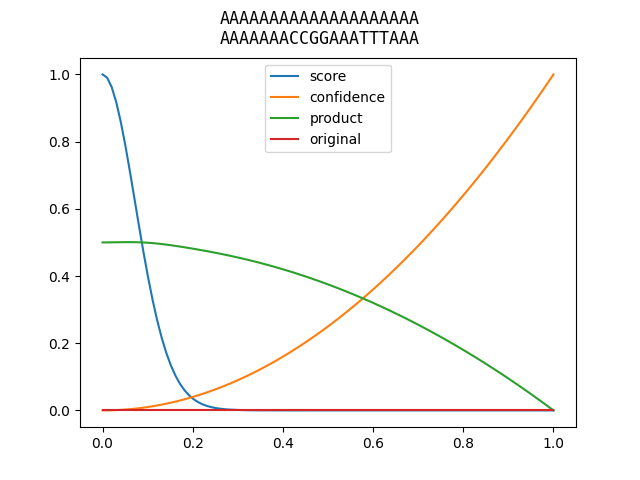

<IPython.core.display.Javascript object>


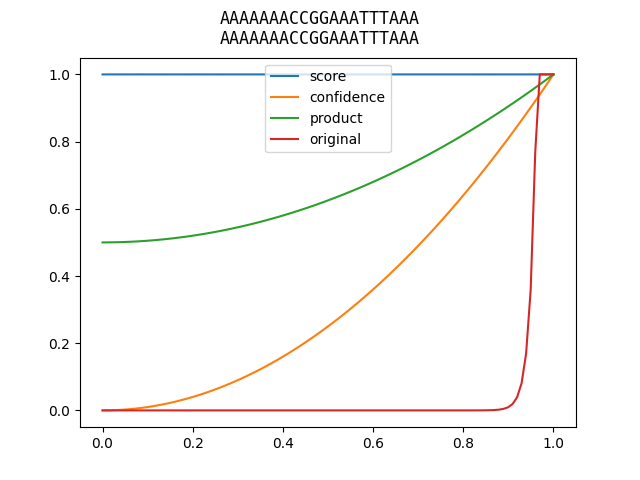

In [7]:
### 
# Take a pair of flat vectors as starting points, and slowly change them to a final point
###

from scipy.interpolate import interp1d

def dotproduct_crispr_spec(seq_pairs):
    """Alternative cleave rate model
    
    Normalize the softmax inputs, and take the penalty at each position to be
    one minus the dot product of the two "base vectors", weighted according to the 
    position dependent substitution penalty from the finkelstein paper.
    
    This ignores the base dependent weighting -- i.e. difference between substituting
    A, T, C, or G -- but allows base outputs which are less confident but still
    similar to be evaluated as such during training. 
    
    With the previous function, an input like [0.8, 0.066, 0.066, 0.0.66] / [0.8, 0.066, 0.066, 0.0.66]
    at a single base results in a substantial penalty to cleave rate.
    """
    subpen = np.array([-1.7449405080809126, -1.275485084790358, -1.8001827224086722, -1.9323849500279549, -1.6677722398632207, -1.6537370694565101, -1.8981469677400609, -1.0814292717607923, -1.3231152511430453, -0.99840146446464273, -1.2766126030502924, -1.073338813454068, -1.5614374592181826, -1.4737507320504855, -1.298392565410591, -1.0105000195452765, -0.43349702574711524, -0.11665543376814178, -0.17370266801790191, 0.2676084623705467, 0.051835157750172757, 0.08920809165894289, 0.075459598643889569, 0.046975071077932237]).astype(np.float32)
    subpen = subpen[:20][::-1]
    ref, _ = tf.linalg.normalize(seq_pairs[:, 0, :, :], axis=-1)
    obs, _ = tf.linalg.normalize(seq_pairs[:, 1, :, :], axis=-1)
    
    x = 1 -  tf.reduce_sum(ref*obs, axis=-1)
    
    scores = tf.reduce_sum(x * tf.constant(subpen.flatten(), dtype=tf.float32), -1)
    return scores

def dotproduct_linearized(mid_point=None):
    """Returns a predictor function which will scale the log10 scores such that the
    given `mid_point` value is 0.5.
    
    mid_point is the output of log10_crispr_spec, and shoudl be on range [log10_lb, log10_ub]
    
    If mid_point is none, cleave rate is linearized; i.e. return 10**log_10_crispr_spec(x)
    """
    power = 10
    if mid_point is not None:
        power = 0.5 ** (1 / mid_point)

    def f(seq_pairs):
        """
        seq_pairs batch_size x 2 x SEQLEN x 4
        """
        scores = power ** dotproduct_crispr_spec(seq_pairs)
        confidence = tf.reduce_mean((tf.reduce_max(seq_pairs, -1) - 0.25)/0.75, axis=2)
        confidence = tf.reduce_prod(confidence, axis=1)
        return 0.5 + (scores - 0.5), confidence

    return f


def plot_transition(final_pairs):
    # Start from a completely random softmax vector, where every position has 
    # 25% probaility of being each base
    random_seq = np.repeat(np.array([0.25, 0.25, 0.25, 0.25])[:, None], 20, axis=1).T
    start_pair = np.repeat(random_seq[None, :, :], 2, axis=0)
    
    # Create softmax version of the ending pair sequence values
    end_pair = seqtools.seqs_to_onehots(final_pairs)
    
    # create array of softmax pairs by interpolating between the start and end,
    # to simulate the training path of moving from random vectors to that
    # particular onehot vector
    end_interp = interp1d([0.0, 1.0], np.array([start_pair, end_pair]), axis=0)
    x = np.linspace(0.0, 1.0, 100)
    pair_array = end_interp(x)
    
    scores, confidence = dotproduct_linearized()(tf.convert_to_tensor(pair_array, dtype=np.float32))
    old_scores = linear_crispr_spec()(tf.convert_to_tensor(pair_array, dtype=np.float32))
    plt.figure()
    plt.plot(x, scores, label='score')
    plt.plot(x, confidence, label='confidence')
    plt.plot(x, 0.5 + (scores - 0.5) * confidence, label='product')
    plt.plot(x, old_scores, label='original')
    plt.suptitle(f"{final_pairs[0]}\n{final_pairs[1]}", fontdict={'family': 'monospace'})
    plt.legend(loc='upper center')

pair1 = [
    'AAAAAAAAAAAAAAAAAAAA',
    'AAAAAAACCGGAAATTTAAA',
]
pair2 = [
    'AAAAAAACCGGAAATTTAAA',
    'AAAAAAACCGGAAATTTAAA',
]

plot_transition(pair1)
plot_transition(pair2)

In [6]:
tf.sqrt(tf.reduce_sum(start_pair[0]*start_pair[0], axis=-1))



<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])>

In [25]:
end_interp(0.5)


array([[[0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125]],

       [[0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0.625, 0.125, 0.125, 0.125],
        [0